In [202]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l
from matplotlib import pyplot as plt

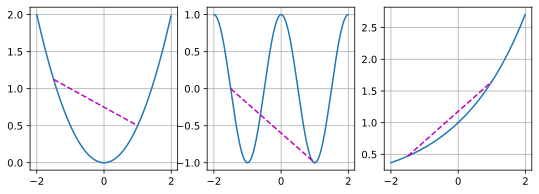

In [2]:
f = lambda x: 0.5 * x**2  # 凸函数
g = lambda x: torch.cos(np.pi * x)  # 非凸函数
h = lambda x: torch.exp(0.5 * x)  # 凸函数

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

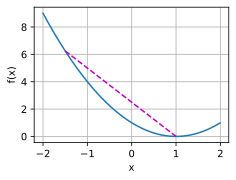

In [3]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

In [60]:
def gd(eta, f_grad):
    x = 0
    results = [x]
    for i in range(100):

        x += eta * f_grad(x)
        results.append(float(x))

    print(f'epoch 100, x: {x:f}')

    return results


def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(0, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

In [198]:
def train_2d(trainer, steps=20, f_grad=None):  #@save
    """用定制的训练机优化2D目标函数"""
    # s1和s2是稍后将使用的内部状态变量
    x1, x2, s1, s2 = 0, 0, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):  #@save
    """显示优化过程中2D变量的轨迹"""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-0.0, 1.0, 0.1),
                          torch.arange(-0.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

In [211]:

N = 100
M = 100
aaa = 1.5
eta = 0.000001
r_d2d = 30
r_bs = 100
value = (r_d2d/r_bs)**2
cap = 4

def zipf_distribute(alpha, file_number):
    ans = np.zeros(file_number)
    sum = 0
    for i in range(1, file_number + 1):
        sum += 1 / pow(i, alpha)
    for i in range(1, file_number + 1):
        ans[i - 1] = (1 / pow(i, alpha)) / sum
    return ans

zipf_n = zipf_distribute(aaa,M)

def d2d(a,x):
    return a-a*np.exp(-1.0*value* N * x)+a*x*np.exp(-1.0*value* N * x)

def d2d_grad(a,x):
    return value*N*a*np.exp(-1.0*value* N * x)-a*x*value*np.exp(-1.0* N *value* x)+a*np.exp(-1.0*value* N * x)

def gd_d2d(results,f_grad):
    ans = np.copy(results)
    for i in range(len(results)):
        if ans[i]>=1:
            continue
        ans[i]=ans[i]+eta*f_grad(zipf_n[i],ans[i])


    return ans


In [212]:
def train_d2d(trainer,step=100,f_grad=None):
    results=np.zeros(M)
    for i in range(step):
        if results.sum()>cap:
            break
        results=np.copy(trainer(results,f_grad))
    return results


result = train_d2d(gd_d2d,100000,d2d_grad)
print(result.sum())


0.6595495900417624


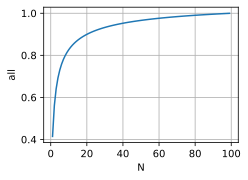

In [115]:

def all_request(xx):
    return zipf_n[:xx].sum()

xxxx=np.arange(1,100,1)
yyyy=np.zeros(len(xxxx))
for i in range(len(xxxx)):
    yyyy[i]=all_request(xxxx[i])

d2l.plot([xxxx,],[yyyy,],'N','all')

In [80]:
def all_d2d(results,f_func):
    ans=0
    for i in range(len(results)):

        ans+=f_func(zipf_n[i],results[i])
    return ans

print(all_d2d(result,d2d))

0.7255232040345682


In [154]:
lr = 1/(M*10)

def d2d_gd(capacity):
    k = capacity*M*10
    results = np.zeros(N)
    for i in range(k):
        max=0
        index=0
        for j in range(len(results)):
            if d2d(zipf_n[j],results[j]+lr)-d2d(zipf_n[j],results[j])>max:
                max =d2d(zipf_n[j],results[j]+lr)-d2d(zipf_n[j],results[j])
                index=j


        results[index]+=lr
    return results

result_gd = d2d_gd(cap)

In [155]:
print('梯度下降占用总容量：',result.sum())
print('梯度下降的命中概率：',all_d2d(result,d2d))
print('贪婪算法占用总容量：',result_gd.sum())
print('贪婪算法的命中概率：',all_d2d(result_gd,d2d))

梯度下降占用总容量： 4.000089676451918
梯度下降的命中概率： 0.8330186756418736
贪婪算法占用总容量： 4.000000000000003
贪婪算法的命中概率： 0.8558597846057414


In [146]:
all_d2d(result_gd,d2d)
aaaaaa =0.8558276510081465

0.8558276510081465

In [153]:
M*10*4*lr

400.0

In [157]:
d2d(zipf_n[0],result[0])

0.40985876797861265

In [158]:
d2d(zipf_n[0],result_gd[0])

0.4120642883007685

In [209]:
l_m=0.9
def d2d_seg(f_m,h_m): #目标函数
    a=(1-l_m)*(f_m+(1-f_m)*(1-np.exp(-1*N*value*f_m)))
    b=l_m*((f_m+h_m)+(1-f_m-h_m)*(1-np.exp(-1*N*value*(f_m+h_m))))
    #print(a,b)
    #print(f_m,h_m)
    print(a+b)
    return  (a+b)

def d2d_seg_grad(f_m,h_m): #目标函数的梯度
    z=value*N
    a_f = (1-l_m)*(z+1-z*f_m)*np.exp(-1*z*f_m)
    b_f = l_m*(1+z-f_m*z-h_m*z)*np.exp(-1*z*(f_m+h_m))
    a_h = 0
    b_h = l_m*(1+z-f_m*z-h_m*z)*np.exp(-1*z*(f_m+h_m))
    #限制条件为f+h*0.5<=S
    #增加1的h只会使用1/2的存储空间
    print(a_f+b_f,a_h+b_h)
    return  (a_f+b_f,a_h+b_h)

def d2d_seg_trainer(f_m,h_m,s1, s2, f_grad): #目标函数的2d
    g1,g2 = f_grad(f_m,h_m)
    return  (f_m+eta*g1,h_m+eta*g2,0,0)

# def train_d2d(trainer, steps=20, f_grad=None):
#     x1, x2, s1, s2 = -5, -2, 0, 0
#     results = [(x1, x2)]
#     for i in range(steps):

x = 0.3
l = 0.9
ffff=np.arange(max(0,x-0.5),x,0.01)
hhhh=2*x-2*ffff

d2d_seg_grad(ffff,2*x-2*ffff)
# d2l.plot([ffff,],[d2d_seg_grad(ffff,2*x-2*ffff)],'x','f(x)_grad')

# eta=0.01
# show_trace_2d(d2d_seg,train_2d(d2d_seg_trainer,100,f_grad=d2d_seg_grad))





[1.01869865 0.92656568 0.84349768 0.76870053 0.70145879 0.64112898
 0.58713359 0.53895567 0.49613401 0.45825883 0.42496792 0.3959433
 0.37090821 0.34962457 0.33189074 0.31753964 0.30643725 0.29848133
 0.29360054 0.29175374 0.29292973 0.29714711 0.30445457 0.31493133
 0.32868803 0.34586776 0.36664752 0.39123993 0.41989535 0.45290428] [0.01869865 0.02085987 0.02326233 0.02593228 0.02889881 0.03219409
 0.03585374 0.03991715 0.04442792 0.04943427 0.05498953 0.0611527
 0.067989   0.07557056 0.08397712 0.09329682 0.10362709 0.11507562
 0.12776143 0.141816   0.15738464 0.17462788 0.19372304 0.21486601
 0.23827314 0.26418336 0.29286054 0.32459604 0.35971156 0.39856226]


(array([1.01869865, 0.92656568, 0.84349768, 0.76870053, 0.70145879,
        0.64112898, 0.58713359, 0.53895567, 0.49613401, 0.45825883,
        0.42496792, 0.3959433 , 0.37090821, 0.34962457, 0.33189074,
        0.31753964, 0.30643725, 0.29848133, 0.29360054, 0.29175374,
        0.29292973, 0.29714711, 0.30445457, 0.31493133, 0.32868803,
        0.34586776, 0.36664752, 0.39123993, 0.41989535, 0.45290428]),
 array([0.01869865, 0.02085987, 0.02326233, 0.02593228, 0.02889881,
        0.03219409, 0.03585374, 0.03991715, 0.04442792, 0.04943427,
        0.05498953, 0.0611527 , 0.067989  , 0.07557056, 0.08397712,
        0.09329682, 0.10362709, 0.11507562, 0.12776143, 0.141816  ,
        0.15738464, 0.17462788, 0.19372304, 0.21486601, 0.23827314,
        0.26418336, 0.29286054, 0.32459604, 0.35971156, 0.39856226]))

In [195]:
d2d_seg_grad(0.1,0.1)

(2.0587507894837422, 0.9488156183919065)